# Best and worst molecules analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from scipy import stats
from torch.nn.utils.rnn import pad_sequence
from sklearn.neural_network import MLPRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.metrics import mean_squared_error, r2_score
import time

## Getting the data ready

In [2]:
data_train = pd.read_csv('../../data/3_final_data/split_data/logP_wo_averaging_train.csv', index_col=0)
data_valid = pd.read_csv('../../data/3_final_data/split_data/logP_wo_averaging_validation.csv', index_col=0)
data_test = pd.read_csv('../../data/3_final_data/split_data/logP_wo_averaging_test.csv', index_col=0)

In [3]:
y_train = data_train.logP
y_valid = data_valid.logP
y_test = data_test.logP

In [4]:
X_train_mol = [Chem.MolFromSmiles(x) for x in data_train.smiles]
X_valid_mol = [Chem.MolFromSmiles(x) for x in data_valid.smiles]
X_test_mol = [Chem.MolFromSmiles(x) for x in data_test.smiles]

## Building the model

In [5]:
def get_morgan_count_fps(data, bits=2048, radius=2):
    X = [AllChem.GetHashedMorganFingerprint(m, radius, nBits=bits) for m in data]
    X_list = []
    for x in X:
        array = np.zeros((0,), dtype=np.int64)
        DataStructs.ConvertToNumpyArray(x, array)
        X_list.append(array)
    X = pd.DataFrame(X_list)
    return X

In [6]:
start_time = time.time()

X_train = get_morgan_count_fps(X_train_mol)
X_valid = get_morgan_count_fps(X_valid_mol)

regr = MLPRegressor(random_state=10, max_iter=1, warm_start=True)

valid_rmse = 10 ** 3
epoch_count = 1
valid_rmses = []
train_rmses = []
valid_r2s = []
train_r2s = []

y_predicted = regr.fit(X_train, y_train).predict(X_valid)
rmse = mean_squared_error(y_valid, y_predicted, squared = False)
while rmse < valid_rmse:
    valid_rmse = rmse
    train_rmse = mean_squared_error(y_train, regr.predict(X_train), squared = False)
    valid_rmses.append(valid_rmse)
    train_rmses.append(train_rmse)
    
    valid_r2 = r2_score(y_valid, y_predicted)
    valid_r2s.append(valid_r2)
    
    train_r2 = r2_score(y_train, regr.predict(X_train))
    train_r2s.append(train_r2)
    
    epoch_count += 1
    regr.fit(X_train, y_train)
    y_predicted = regr.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_predicted, squared = False)

valid_rmses.append(rmse)
train_rmses.append(mean_squared_error(y_train, regr.predict(X_train), squared = False))

valid_r2s.append(r2_score(y_valid, y_predicted))
train_r2s.append(r2_score(y_train, regr.predict(X_train)))
    
seconds = time.time() - start_time
print("Fitting with params radius=2, bits=2048 finished. RMSE={0} was achieved after {1} epochs in {2:.2f} seconds\n".
      format(rmse, epoch_count, seconds))

C:\Users\lizzka239\anaconda3\envs\chemvae\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Fitting with params radius=2, bits=2048 finished. RMSE=0.5899868210853979 was achieved after 8 epochs in 68.96 seconds



In [7]:
rmses = pd.DataFrame({'train_rmses':train_rmses, 'valid_rmses' : valid_rmses})

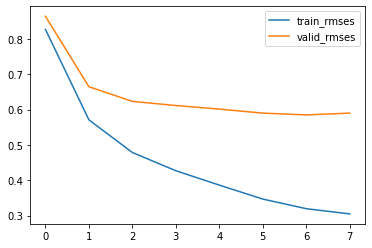

In [8]:
rmses.plot()

In [9]:
r2s = pd.DataFrame({'train_r2':train_r2s, 'valid_r2' : valid_r2s})

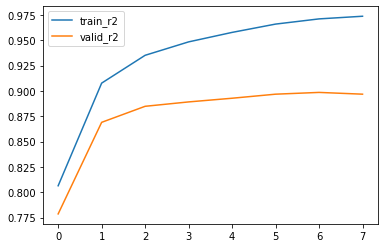

In [10]:
r2s.plot()

In [11]:
X_train = get_morgan_count_fps(X_train_mol)
X_valid = get_morgan_count_fps(X_valid_mol)
X_test = get_morgan_count_fps(X_test_mol)

In [12]:
y_predicted = regr.predict(X_train)
print("Train RMSE =", mean_squared_error(y_train, y_predicted, squared=False))
print("Train R2-score is {0}".format(r2_score(y_train, y_predicted)))

y_predicted = regr.predict(X_valid)
print("Valid RMSE =", mean_squared_error(y_valid, y_predicted, squared=False))
print("Valid R2-score is {0}".format(r2_score(y_valid, y_predicted)))

y_predicted = regr.predict(X_test)
print("Test RMSE =", mean_squared_error(y_test, y_predicted, squared=False))
print("Test R2-score is {0}".format(r2_score(y_test, y_predicted)))

Train RMSE = 0.3049080363008514
Train R2-score is 0.973676560749067
Valid RMSE = 0.5899868210853979
Valid R2-score is 0.8967623937969657
Test RMSE = 0.617056704102343
Test R2-score is 0.8869337762747754


In [13]:
regr.coefs_[1].shape

(100, 1)

## Getting the data to compare

In [14]:
compare_data = pd.DataFrame({'smiles': data_test.smiles, 'y_expected': y_test, 'y_predicted': y_predicted})

In [15]:
compare_data.head()

,smiles,y_expected,y_predicted
0,CC(=O)NC(Cc1ccccc1)C(=O)NC(Cc1ccccc1)C(=O)N(C)...,2.63,2.888887
1,CC(C)n1c(/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c(-c2...,4.17,3.302138
2,CCS(=O)c1sc(C(C)=O)c(N)c1C#N,1.82,1.717331
3,O=P(Oc1ccccc1)(Oc1ccccc1)Oc1ccccc1,4.59,4.164523
4,OC1(c2cc(Cl)ccc2Cl)CCCCC1n1cncn1,3.24,3.851049


In [16]:
compare_data.shape

(2067, 3)

In [17]:
compare_data['error'] = (compare_data.y_expected - compare_data.y_predicted) ** 2

In [18]:
compare_data.sort_values(by=['error'], ascending=False).head()

,smiles,y_expected,y_predicted,error
243,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,12.294830,46.169715
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,7.873687,33.798954
1727,O=S(=O)(O)c1cc(N=c2[nH]c(N3CCOCC3)nc(=Nc3ccccc...,1.48,6.123115,21.558521
1923,CC(N)(C(=O)O)c1cccc2ccccc12,-0.22,3.076372,10.866071
1824,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,2.934415,9.887344


In [19]:
compare_data.sort_values(by=['error'], ascending=True).head()

,smiles,y_expected,y_predicted,error
415,O=Cc1ccc(C(=O)O)cc1,1.76,1.760622,3.868024e-07
1365,C=CCS(=O)(=O)c1cc(OC)c(OC)c(OC)c1,1.34,1.341002,1.003633e-06
1948,Cc1cccc(Cl)c1,3.28,3.281063,1.130709e-06
494,O=c1[nH]nc(CSc2ccccc2)[nH]1,1.46,1.461262,1.591960e-06
1034,COc1ccc([C@@H](C)n2c(C)c3c(C)nnc(C)c3c2C)cc1,3.43,3.428463,2.362289e-06


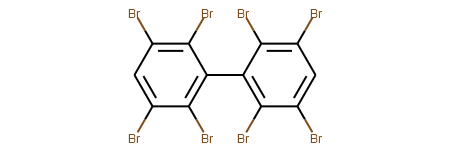

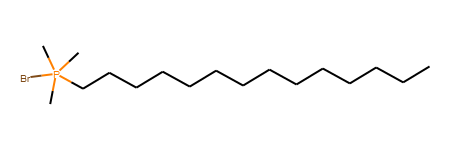

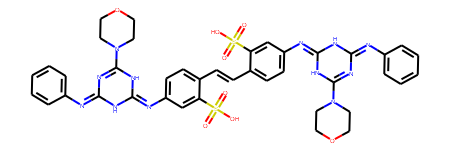

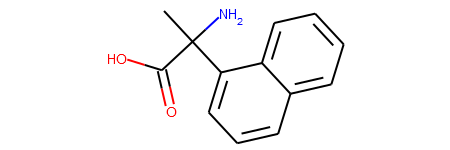

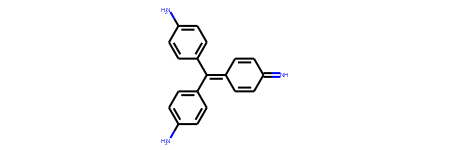

In [20]:
for mol in compare_data.sort_values(by=['error'], ascending=False).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

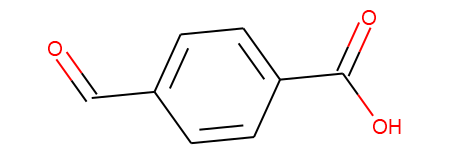

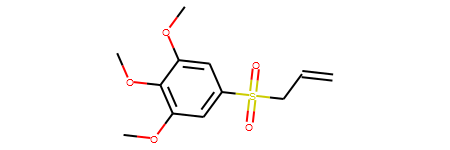

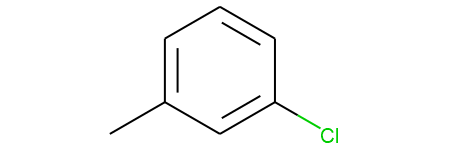

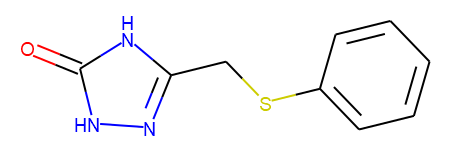

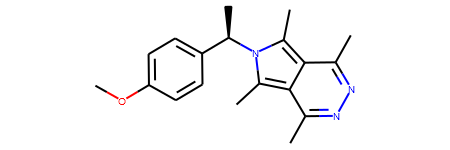

In [21]:
for mol in compare_data.sort_values(by=['error'], ascending=True).head().smiles:
    mol = Chem.MolFromSmiles(mol)
    display(mol)

In [22]:
compare_data = compare_data.sort_values(by=['error'])

## Creating comparing function
### The features to compare:
- The count of atoms
- The count of rings
- The count of not organogens atoms
- The percent of not organogens atoms
- The percent of aromatic (benzene) rings out of all rings

In [23]:
def create_statistics(vals):
    values = vals.copy()
    mols = [Chem.MolFromSmiles(x) for x in values.smiles]
    
    atom_count = [mol.GetNumAtoms() for mol in mols]
    values['atom_count'] = pd.Series(atom_count)
    
    values['ring_count'] = pd.Series([mol.GetRingInfo().NumRings() for mol in mols])
    
    mol_atoms = [mol.GetAtoms() for mol in mols]
    non_simple_atom_count = [sum((num.GetAtomicNum() not in [1, 6, 8, 7]) for num in m_atoms) for m_atoms in mol_atoms]
    values['non_organogens_count'] = pd.Series(non_simple_atom_count)
    
    values['non_organogens_percent'] = values.non_organogens_count / values.atom_count *100
    
    benzene_smiles = 'C1=CC=CC=C1'
    pattern = Chem.MolFromSmiles(benzene_smiles)
    values['aromatic_count'] = pd.Series([len(mol.GetSubstructMatches(pattern)) for mol in mols])
    
    values['aromatic_rings_percent'] = values.aromatic_count / values.ring_count *100
    values['aromatic_rings_percent'] = values['aromatic_rings_percent'].fillna(0)
    
    values['bond_count'] =  [len(mol.GetBonds()) for mol in mols]
    values['aromatic_bond_count'] = [sum(bond.GetIsAromatic() for bond in mol.GetBonds()) for mol in mols]
    values['aromatic_bond_percent'] = values.aromatic_bond_count / values.bond_count * 100
    
    values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in mols]
    values['is_symmetric'] =  [len(values) == len(values[values % 2 == 0]) for values in values_list]
    
    return values

## Analyzing the data features

In [24]:
compare_data_with_stats = create_statistics(compare_data)

In [25]:
compare_data_with_stats.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
415,O=Cc1ccc(C(=O)O)cc1,1.76,1.760622,3.868024e-07,18,3,0,0.0,0,0.000000,11,6,54.545455,False
1365,C=CCS(=O)(=O)c1cc(OC)c(OC)c(OC)c1,1.34,1.341002,1.003633e-06,23,2,0,0.0,2,100.000000,18,6,33.333333,False
1948,Cc1cccc(Cl)c1,3.28,3.281063,1.130709e-06,40,5,0,0.0,1,20.000000,8,6,75.000000,False
494,O=c1[nH]nc(CSc2ccccc2)[nH]1,1.46,1.461262,1.591960e-06,20,3,0,0.0,2,66.666667,15,11,73.333333,False
1034,COc1ccc([C@@H](C)n2c(C)c3c(C)nnc(C)c3c2C)cc1,3.43,3.428463,2.362289e-06,14,1,0,0.0,0,0.000000,25,16,64.000000,False


#### Splitting data into 3 parts

In [26]:
data = []
for i in range(3):
    data.append(compare_data_with_stats.take([j for j in range(i * 1894 // 3, min((i + 1) * 1894 // 3, 1894))]))

In [27]:
data[0].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,6.310000e+02,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.111537,2.116012,9.072416e-03,17.518225,1.776545,0.851030,5.386861,0.933439,55.537695,17.562599,7.437401,43.968384
std,1.644619,1.641400,7.636286e-03,7.716972,1.197546,1.306879,9.060356,0.744508,41.557905,7.595036,4.216234,22.840050
min,-2.710000,-2.627507,3.868024e-07,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.995000,1.032955,1.786947e-03,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,31.578947
50%,2.000000,2.018959,7.339706e-03,16.000000,1.000000,0.000000,0.000000,1.000000,50.000000,17.000000,6.000000,45.454545
75%,3.075000,3.073949,1.556109e-02,21.000000,2.000000,1.000000,7.692308,1.000000,100.000000,21.000000,11.000000,60.000000
max,8.200000,8.100064,2.517608e-02,65.000000,8.000000,8.000000,80.000000,5.000000,100.000000,62.000000,23.000000,100.000000


In [28]:
data[1].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,631.000000,631.000000,631.000000,631.000000,631.000000,631.00000,631.000000,631.000000,631.000000,631.000000,631.000000,631.000000
mean,2.202552,2.248260,0.072020,17.879556,1.770206,0.89065,5.349272,0.944532,54.146857,17.307448,7.549921,44.572336
std,1.822568,1.808931,0.033435,7.673170,1.165428,1.47436,9.038098,0.779763,41.190810,7.112738,4.545044,23.056198
min,-2.450000,-2.177420,0.025247,5.000000,0.000000,0.00000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.955000,1.079221,0.042714,12.000000,1.000000,0.00000,0.000000,0.000000,0.000000,12.000000,6.000000,31.578947
50%,2.100000,2.122340,0.066512,17.000000,2.000000,0.00000,0.000000,1.000000,50.000000,16.000000,6.000000,46.153846
75%,3.200000,3.195387,0.097531,21.000000,2.000000,1.00000,7.142857,1.000000,100.000000,21.000000,11.000000,60.000000
max,8.600000,8.334260,0.144636,62.000000,8.000000,10.00000,80.000000,5.000000,100.000000,55.000000,27.000000,100.000000


In [29]:
data[2].describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000,632.000000
mean,2.140032,2.252373,0.394646,17.382911,1.784810,0.870253,5.403108,0.928797,54.564497,19.148734,7.841772,41.906644
std,1.871057,1.823607,0.221310,7.758778,1.178743,1.328322,8.842594,0.761386,41.339577,8.918900,5.438633,25.196420
min,-3.700000,-2.822160,0.145135,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
25%,0.907500,1.023959,0.217894,13.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.000000,6.000000,27.272727
50%,2.110000,2.217656,0.330765,16.000000,2.000000,0.000000,0.000000,1.000000,50.000000,17.000000,6.000000,45.833333
75%,3.315000,3.434451,0.508498,20.000000,2.000000,1.000000,8.333333,1.000000,100.000000,24.000000,12.000000,60.000000
max,8.030000,7.698924,1.029755,85.000000,9.000000,8.000000,100.000000,4.000000,100.000000,72.000000,30.000000,100.000000


## Check repeting patterns in the middle of the dataset
Hypothesis: badly predicted molecules are symmetric (like 1, 3, 5 worst molecules)

The simplest way to check: take 20 random molecules from the best/middle/worst part.

In [30]:
best = data[0].reset_index().drop(columns=['index'])

In [31]:
best.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,O=Cc1ccc(C(=O)O)cc1,1.76,1.760622,3.868024e-07,18,3,0,0.0,0,0.000000,11,6,54.545455,False
1,C=CCS(=O)(=O)c1cc(OC)c(OC)c(OC)c1,1.34,1.341002,1.003633e-06,23,2,0,0.0,2,100.000000,18,6,33.333333,False
2,Cc1cccc(Cl)c1,3.28,3.281063,1.130709e-06,40,5,0,0.0,1,20.000000,8,6,75.000000,False
3,O=c1[nH]nc(CSc2ccccc2)[nH]1,1.46,1.461262,1.591960e-06,20,3,0,0.0,2,66.666667,15,11,73.333333,False
4,COc1ccc([C@@H](C)n2c(C)c3c(C)nnc(C)c3c2C)cc1,3.43,3.428463,2.362289e-06,14,1,0,0.0,0,0.000000,25,16,64.000000,False


In [32]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=10))

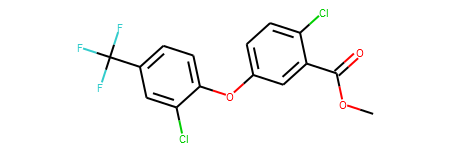

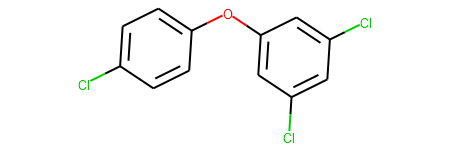

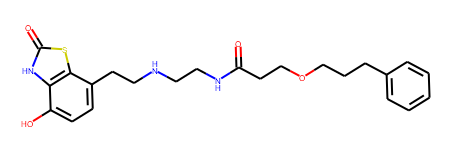

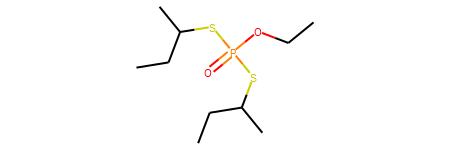

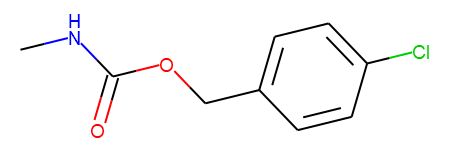

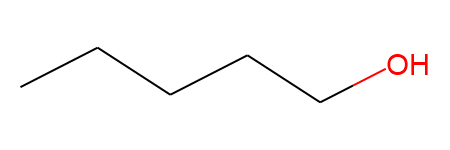

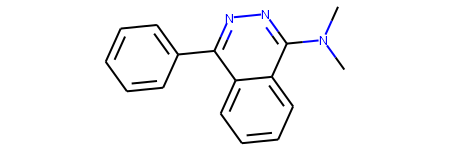

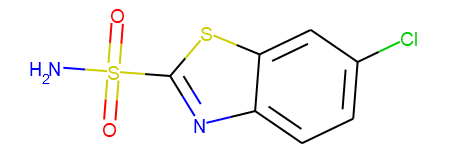

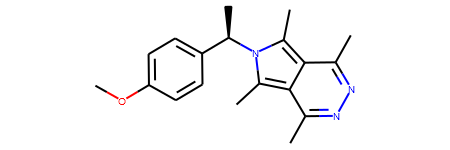

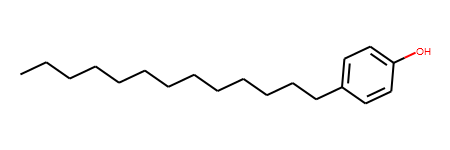

In [33]:
for smiles in best.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [34]:
np.random.seed = 10
indices = pd.Series(np.random.randint(631, size=20))

In [35]:
middle = data[1].reset_index().drop(columns=['index'])

In [36]:
middle.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
0,Cc1cccc(C)c1NC(=O)c1ccc(CN2CCCCC2)cc1,3.86,4.018892,0.025247,15,1,0,0.000000,0,0.000000,26,12,46.153846,False
1,O=C(O)COc1cc(F)cc(Cl)c1,2.20,2.040906,0.025311,21,3,1,4.761905,2,66.666667,13,6,46.153846,False
2,Nc1ccc2cc3ccccc3nc2c1,2.77,2.929426,0.025417,12,1,0,0.000000,1,100.000000,17,16,94.117647,False
3,N#CN=[N+]([O-])c1cc[n+]([O-])cc1,-0.41,-0.570251,0.025680,9,1,0,0.000000,1,100.000000,12,6,50.000000,False
4,CC(C)CC(=O)NC(N)=O,0.45,0.288573,0.026059,24,3,0,0.000000,1,33.333333,9,0,0.000000,False


In [37]:
middle.shape

(631, 14)

In [38]:
indices = pd.Series(np.random.randint(631, size=20))

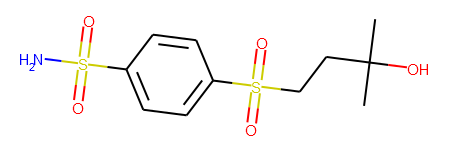

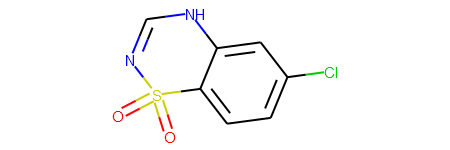

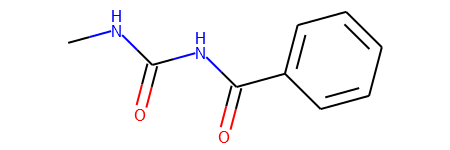

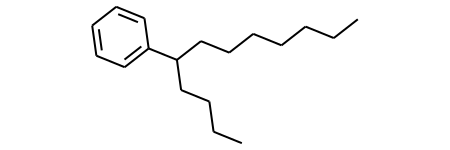

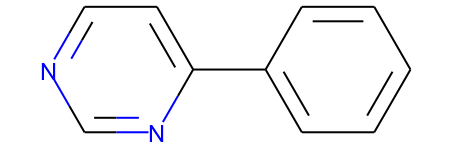

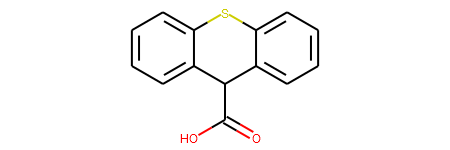

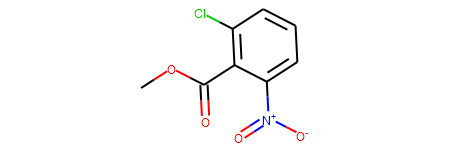

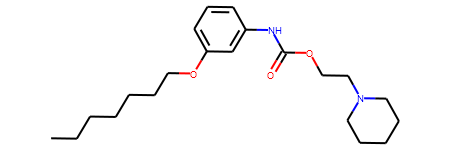

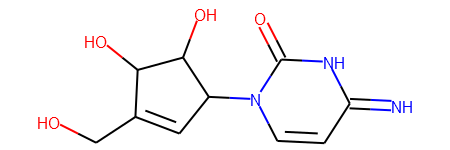

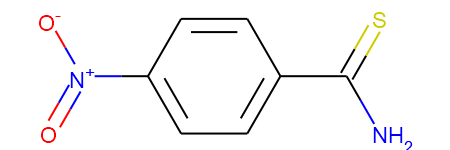

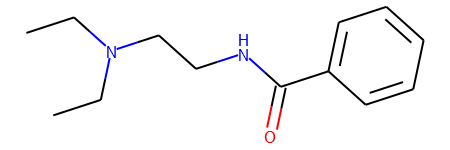

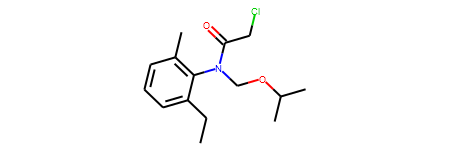

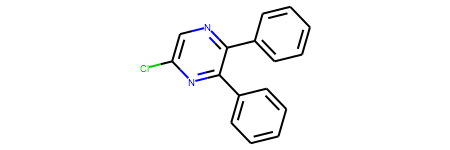

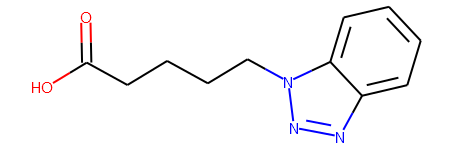

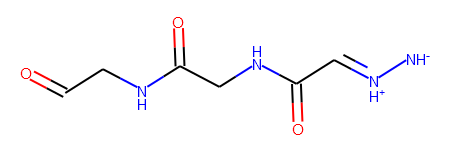

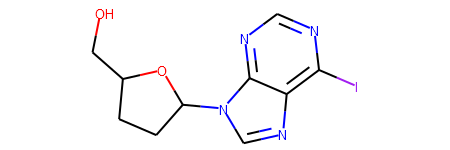

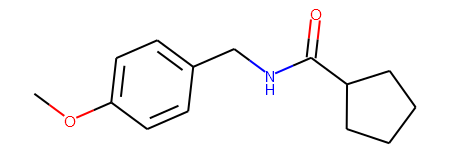

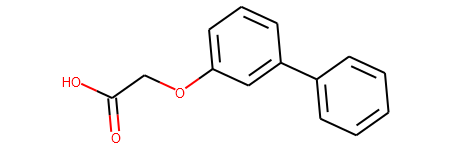

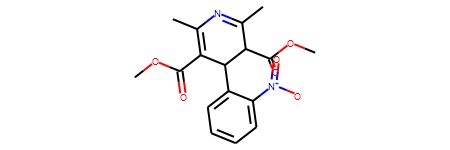

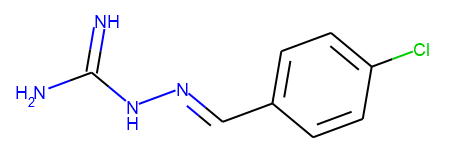

In [39]:
for smiles in middle.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

In [40]:
worst = data[2].reset_index().drop(columns=['index'])

In [41]:
indices = pd.Series(np.random.randint(631, size=20))

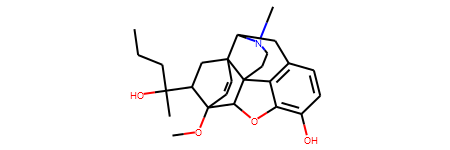

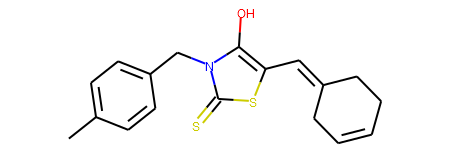

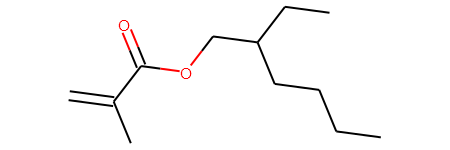

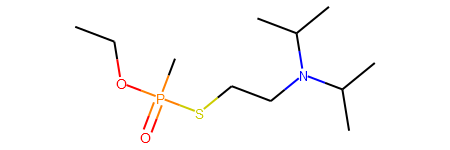

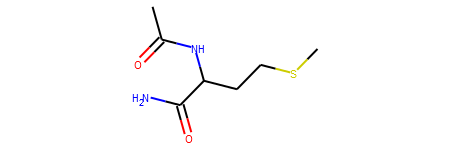

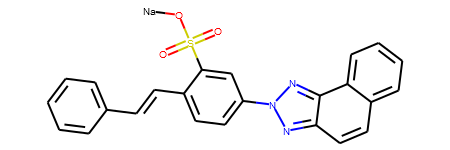

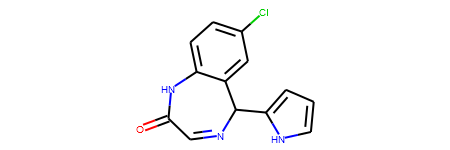

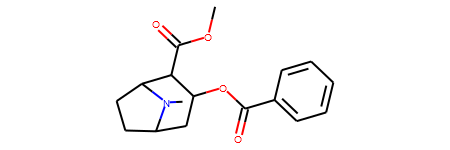

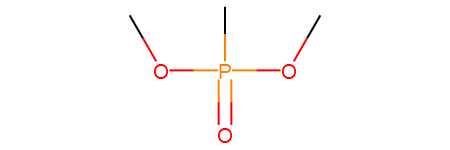

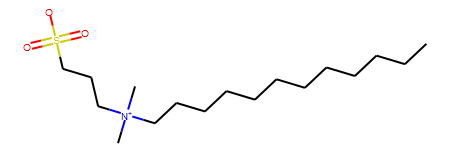

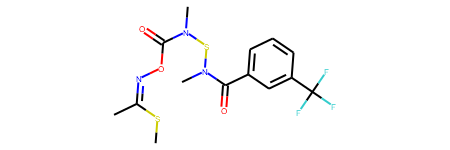

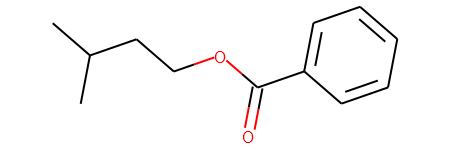

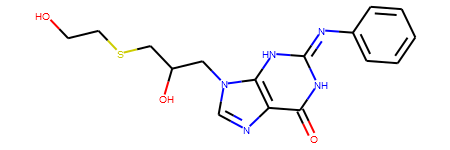

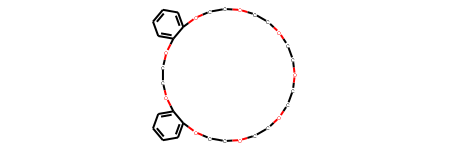

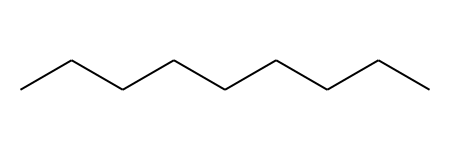

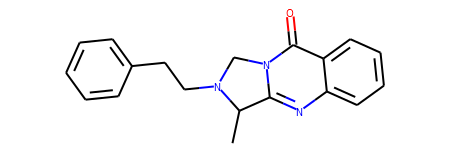

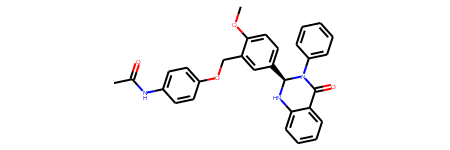

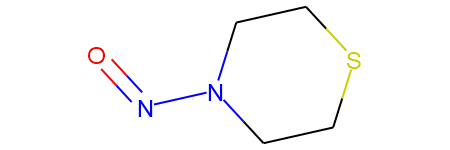

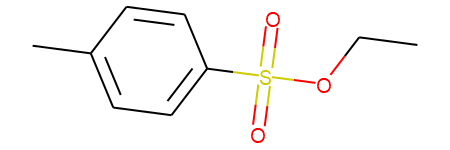

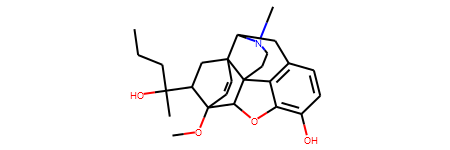

In [42]:
for smiles in worst.loc[indices].smiles:
    mol = Chem.MolFromSmiles(smiles)
    display(mol)

#### Taking best and worst predicted values

In [73]:
n_values = 200

In [74]:
best_n_vals = compare_data_with_stats.take([j for j in range(n_values)])

In [75]:
worst_n_vals = compare_data_with_stats.take([j for j in range( len(compare_data.smiles) - 1, len(compare_data.smiles) - 1 - n_values, -1)])

In [76]:
best_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
415,O=Cc1ccc(C(=O)O)cc1,1.76,1.760622,3.868024e-07,18,3,0,0.0,0,0.000000,11,6,54.545455,False
1365,C=CCS(=O)(=O)c1cc(OC)c(OC)c(OC)c1,1.34,1.341002,1.003633e-06,23,2,0,0.0,2,100.000000,18,6,33.333333,False
1948,Cc1cccc(Cl)c1,3.28,3.281063,1.130709e-06,40,5,0,0.0,1,20.000000,8,6,75.000000,False
494,O=c1[nH]nc(CSc2ccccc2)[nH]1,1.46,1.461262,1.591960e-06,20,3,0,0.0,2,66.666667,15,11,73.333333,False
1034,COc1ccc([C@@H](C)n2c(C)c3c(C)nnc(C)c3c2C)cc1,3.43,3.428463,2.362289e-06,14,1,0,0.0,0,0.000000,25,16,64.000000,False


In [77]:
worst_n_vals.head()

,smiles,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent,is_symmetric
243,Brc1cc(Br)c(Br)c(-c2c(Br)c(Br)cc(Br)c2Br)c1Br,5.50,12.294830,46.169715,24,3,3,12.5,0,0.0,21,12,57.142857,True
1029,CCCCCCCCCCCCCCP(C)(C)(C)Br,2.06,7.873687,33.798954,9,1,0,0.0,1,100.0,18,0,0.000000,False
1727,O=S(=O)(O)c1cc(N=c2[nH]c(N3CCOCC3)nc(=Nc3ccccc...,1.48,6.123115,21.558521,13,1,0,0.0,1,100.0,69,36,52.173913,True
1923,CC(N)(C(=O)O)c1cccc2ccccc12,-0.22,3.076372,10.866071,8,1,0,0.0,0,0.0,17,11,64.705882,False
1824,N=C1C=CC(=C(c2ccc(N)cc2)c2ccc(N)cc2)C=C1,-0.21,2.934415,9.887344,15,1,0,0.0,1,100.0,24,12,50.000000,False


In [78]:
best_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.792400,1.793695,9.891805e-04,17.605000,1.800000,0.850000,5.725120,0.960000,57.850000,17.695000,6.875000,40.397296
std,1.516765,1.513870,8.409545e-04,8.971702,1.303262,1.395434,10.577757,0.742399,41.112255,8.396097,4.198513,22.930401
min,-2.280000,-2.293581,3.868024e-07,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,0.762500,0.779369,1.890944e-04,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,12.000000,6.000000,29.852941
50%,1.710000,1.718097,7.834343e-04,15.000000,1.000000,0.000000,0.000000,1.000000,66.666667,17.000000,6.000000,41.060026
75%,2.755000,2.742538,1.635166e-03,21.000000,2.000000,1.000000,7.142857,1.000000,100.000000,21.000000,10.000000,55.000000
max,5.970000,5.978902,2.780865e-03,65.000000,8.000000,7.000000,80.000000,4.000000,100.000000,62.000000,23.000000,91.666667


In [79]:
worst_n_vals.describe()

,y_expected,y_predicted,error,atom_count,ring_count,non_organogens_count,non_organogens_percent,aromatic_count,aromatic_rings_percent,bond_count,aromatic_bond_count,aromatic_bond_percent
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,2.213200,2.339405,2.561553,17.635000,1.830000,0.705000,4.450506,0.970000,57.609524,22.895000,8.575000,36.470642
std,2.327798,2.181518,4.349872,7.903423,1.248557,1.159611,7.516509,0.715303,41.247509,13.154053,7.135049,24.357244
min,-3.200000,-2.744658,0.893589,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,0.617500,0.909240,1.123004,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,15.000000,6.000000,18.723517
50%,2.330000,2.316500,1.527613,16.000000,1.500000,0.000000,0.000000,1.000000,50.000000,19.500000,6.000000,40.000000
75%,3.902500,3.731567,2.362391,20.000000,2.000000,1.000000,6.896552,1.000000,100.000000,27.250000,12.000000,54.545455
max,7.490000,12.294830,46.169715,56.000000,7.000000,7.000000,37.500000,3.000000,100.000000,85.000000,36.000000,91.666667


### Check atom_count influence

In [80]:
print(stats.ttest_ind(best_n_vals.atom_count, worst_n_vals.atom_count))

Ttest_indResult(statistic=-0.03548426191195629, pvalue=0.9717113853581331)


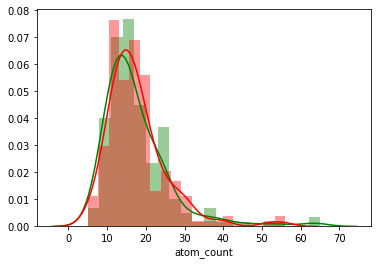

In [81]:
sns.distplot(best_n_vals.atom_count, color='g')
sns.distplot(worst_n_vals.atom_count, color='r')

### Check ring_count influence

In [82]:
print(stats.ttest_ind(best_n_vals.ring_count, worst_n_vals.ring_count))

Ttest_indResult(statistic=-0.2350723654545578, pvalue=0.8142734640147926)


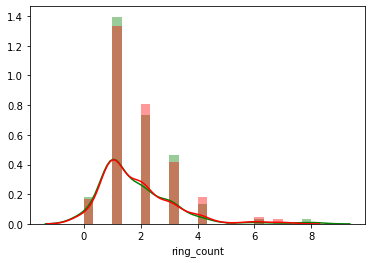

In [83]:
sns.distplot(best_n_vals.ring_count, color='g')
sns.distplot(worst_n_vals.ring_count, color='r')

### Check non_organogens_count influence

In [84]:
print(stats.ttest_ind(best_n_vals.non_organogens_count, worst_n_vals.non_organogens_count))

Ttest_indResult(statistic=1.130205446693319, pvalue=0.2590703091969456)


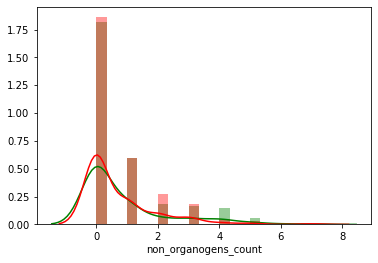

In [85]:
sns.distplot(best_n_vals.non_organogens_count, color='g')
sns.distplot(worst_n_vals.non_organogens_count, color='r')

### Check non_organogens_percent influence

In [86]:
print(stats.ttest_ind(best_n_vals.non_organogens_percent, worst_n_vals.non_organogens_percent))

Ttest_indResult(statistic=1.3891203848442149, pvalue=0.16557287138617774)


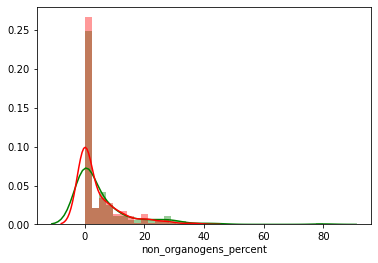

In [87]:
sns.distplot(best_n_vals.non_organogens_percent, color='g')
sns.distplot(worst_n_vals.non_organogens_percent, color='r')

### Check aromatic_count influence

In [88]:
print(stats.ttest_ind(best_n_vals.aromatic_count, worst_n_vals.aromatic_count))

Ttest_indResult(statistic=-0.13717859491580064, pvalue=0.8909589970718015)


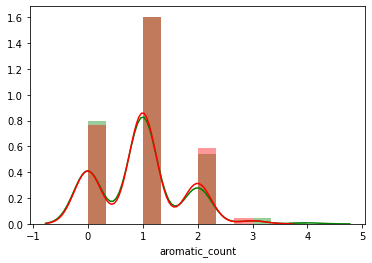

In [89]:
sns.distplot(best_n_vals.aromatic_count, color='g')
sns.distplot(worst_n_vals.aromatic_count, color='r')

### Check aromatic_rings_percent influence

In [90]:
print(stats.ttest_ind(best_n_vals.aromatic_rings_percent, worst_n_vals.aromatic_rings_percent))

Ttest_indResult(statistic=0.058396443721688916, pvalue=0.9534621553068465)


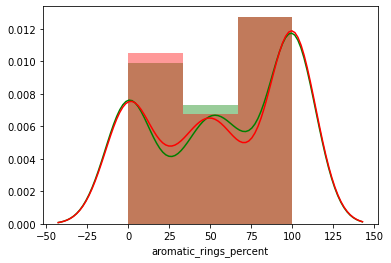

In [91]:
sns.distplot(best_n_vals.aromatic_rings_percent, color='g')
sns.distplot(worst_n_vals.aromatic_rings_percent, color='r')

### Check aromatic bond percent

In [92]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_percent, worst_n_vals.aromatic_bond_percent))

Ttest_indResult(statistic=1.6599969955300746, pvalue=0.09770269341901906)


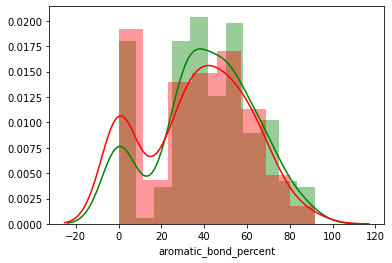

In [93]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check aromatic bond count

In [94]:
print(stats.ttest_ind(best_n_vals.aromatic_bond_count, worst_n_vals.aromatic_bond_count))

Ttest_indResult(statistic=-2.9040438717889634, pvalue=0.0038890553502565254)


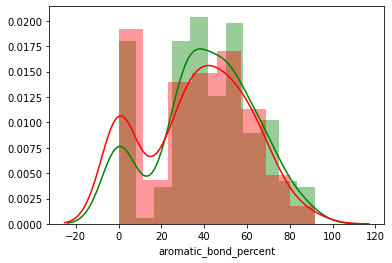

In [95]:
sns.distplot(best_n_vals.aromatic_bond_percent, color='g')
sns.distplot(worst_n_vals.aromatic_bond_percent, color='r')

### Check symmetric count

In [96]:
print(stats.ttest_ind(best_n_vals.is_symmetric, worst_n_vals.is_symmetric))

Ttest_indResult(statistic=-1.9105069180156784, pvalue=0.0567862830071791)


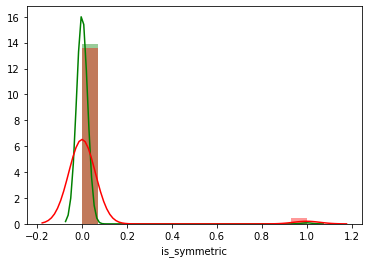

In [97]:
sns.distplot(best_n_vals.is_symmetric, color='g')
sns.distplot(worst_n_vals.is_symmetric, color='r')

### Metrics analysis among symmetric and not symmetric molecules

In [98]:
values_list = [pd.Series(Chem.CanonicalRankAtoms(mol, breakTies=False)).value_counts() for mol in X_test_mol]
symmetric_indices = [len(values) == len(values[values % 2 == 0]) for values in values_list]
    

In [99]:
symmetric_X_test = X_test[symmetric_indices]
symmetric_y_test = y_test[symmetric_indices]

In [100]:
not_symmetric_X_test = X_test[[not e for e in symmetric_indices]]
not_symmetric_y_test = y_test[[not e for e in symmetric_indices]]

In [101]:
symmetric_y_predicted = regr.predict(symmetric_X_test)
print("Test symmetric RMSE =", mean_squared_error(symmetric_y_test, symmetric_y_predicted, squared=False))
print("Test symmetric R2-score is {0}".format(r2_score(symmetric_y_test, symmetric_y_predicted)))

Test symmetric RMSE = 1.4346063149440584
Test symmetric R2-score is 0.6068235979117156


In [102]:
not_symmetric_y_predicted = regr.predict(not_symmetric_X_test)
print("Test not symmetric RMSE =", mean_squared_error(not_symmetric_y_test, not_symmetric_y_predicted, squared=False))
print("Test not symmetric R2-score is {0}".format(r2_score(not_symmetric_y_test, not_symmetric_y_predicted)))

Test not symmetric RMSE = 0.5889098873669556
Test not symmetric R2-score is 0.8947475434552788
